In [2]:
from jax.config import config
from jax import random, jit, value_and_grad
from operator import index
import numpy as np # imports a fast numerical programming library
import scipy as sp #imports stats functions, amongst other things
import matplotlib as mpl # this actually imports matplotlib
import matplotlib.cm as cm #allows us easy access to colormaps
import matplotlib.pyplot as plt #sets up plotting under plt
import pandas as pd #lets us handle data as dataframes
import jax.numpy as jnp # ai-accelerator agnostic numpy implementations
import jax # autograd + XLA
import tensorflow_probability as tfp # tensorflow probability
import seaborn as sns
import warnings
from kernel import kernel_functions, preprocess
warnings.filterwarnings("ignore")

from scipy.optimize import minimize
%matplotlib inline


In [3]:
INFERENCE_COUNT = 1000
tfd = tfp.distributions

# Generating data for eventual inference.

#### Returns a tuple with an X array and the corresponding f(X).

In [4]:
def func(X):
    return jnp.sin(X) + jnp.cos(3*X) + 1/(jnp.sin(2*X) + 2) + jnp.cos(5*X)

In [5]:
def generate_noisy_points(n=30, noise_variance=1e-6):
    np.random.seed(1000)
    X = np.random.uniform(-3., 3., (n, 1))
    y = func(X) + np.random.randn(n, 1) * noise_variance**0.5
    return X, y

In [6]:
MAX = 3.0
MIN = -3.0

#### Plot the points, and the ground-truth function.

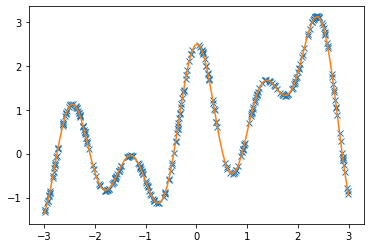

In [7]:
X_test, y_test = generate_noisy_points(300)
plt.plot(X_test, y_test, 'x')
plt.plot(jnp.linspace(MIN, MAX, 100), func(jnp.linspace(MIN, MAX, 100)))
plt.show()
X_test.sort(axis=0)

In [8]:
X, y = generate_noisy_points(INFERENCE_COUNT)

Our ground-truth is the orange function, and the points of inference are blue Xs.

# Import ```gp.py``` and ```kernel.py```.

In [9]:
from gp import gaussian_process
from kernel import kernel_functions, preprocess

gp = gaussian_process(kernel_function_name = "rbf") 
kf = kernel_functions()
pre = preprocess()

#### Setting prior with an RBF kernel; let's sample them and plot them.

In [10]:
jnp.min(X_test)

DeviceArray(-2.986888, dtype=float32)

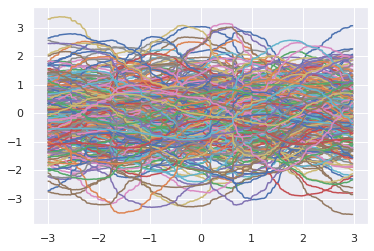

In [11]:
gp_prior = gp.gaussian_prior(X_test, sample_count = 300)
sns.set()
plt.plot(gp_prior["X"], gp_prior["Y"])
plt.show()

### Gaussian Posterior from ```gp.py```. 
#### So ```gp_posterior``` is function-first and ```f_post``` is point-first.

In [12]:
gp_prior_sample = np.array(np.array(gp_prior["Y"]))
gp_prior_infpt = np.array(np.array(gp_prior["X"]))

Plotting ```f_post```.

As we can see, with 10,000 inference points, the approximation is very strong.

Let us try with 5 random points.

In [13]:
from matplotlib.markers import MarkerStyle

In [14]:
X_test = jnp.linspace(-3,3,300)
X_test = X_test.reshape((300,1))

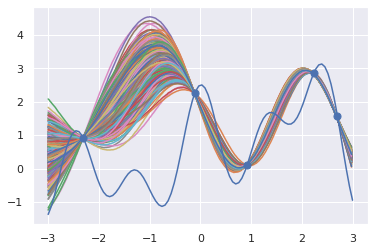

In [15]:
X, y = generate_noisy_points(5, noise_variance=0)

plt.scatter(X, y, s=5e1)
plt.plot(jnp.linspace(MIN, MAX, 100), func(jnp.linspace(MIN, MAX, 100)))

gp_posterior, gp_post_dict, mu, std = gp.gaussian_posterior(
    gp_prior=gp_prior_sample, X_data=X, Y_data=y, X_test=X_test)
for i in range(gp_prior_sample.shape[1]):
    plt.plot(gp_post_dict["X"], gp_posterior[i], zorder=0.9)


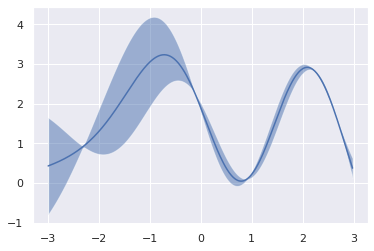

In [16]:
plt.fill_between(x = gp_prior["X"], y1 = mu.reshape(len(mu)) + 2*std, y2 = mu.reshape(len(mu)) - 2*std, alpha = 0.50)
plt.plot(gp_prior["X"], mu)

That's a rather bad approximation -- however, with 10 points, the approximation becomes much better.

In [19]:
X_back = X_test

In [20]:
X_back.shape, X_test.shape

((300, 1), (300, 1))

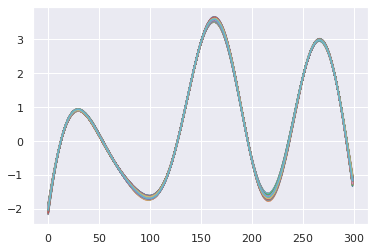

In [21]:
X, y = generate_noisy_points(10, noise_variance = 0)

gp_posterior, f_post, mu, std = gp.gaussian_posterior(gp_prior = gp_prior_sample, X_data = X, Y_data = y, X_test = X_test)
for i in range(gp_prior_sample.shape[1]):
    plt.plot(gp_posterior[i])

#### Sparse Gaussian Processes work on this principle.

We don't need all $ 10,000 $ points to get a good approximation. Our goal is to find the optimal balance, since the complexity grows with $ O(N^3) $, where $ N = $ the number of points in the dataset.

## Nyström Approximation

Choose subset.


In [22]:
TOTAL = 300
SUBSET = 5

In [23]:
subset_list = np.random.choice(X.shape[0], SUBSET, replace=False)
X_subset = X[subset_list]
y_subset = y[subset_list]

Comparison

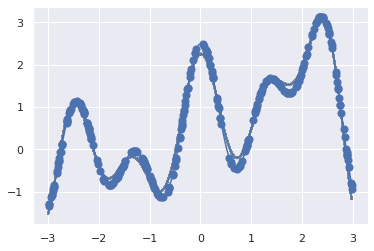

In [24]:
X, y = generate_noisy_points(TOTAL, noise_variance = 0)

plt.scatter(X, y, s=5e1)
plt.plot(jnp.linspace(MIN, MAX, 100), func(jnp.linspace(MIN, MAX, 100)))

gp_posterior, gp_post_dict, mu, std = gp.gaussian_posterior(
    gp_prior=gp_prior_sample, X_data=X, Y_data=y, X_test= X_test)
for i in range(gp_prior_sample.shape[1]):
    plt.plot(gp_post_dict["X"], gp_posterior[i], zorder=0.9)


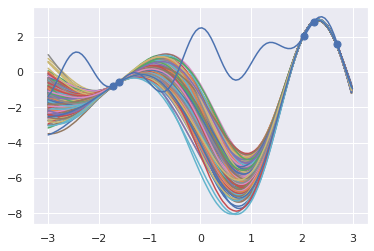

In [25]:

plt.scatter(X_subset, y_subset, s=5e1)
plt.plot(jnp.linspace(MIN, MAX, 100), func(jnp.linspace(MIN, MAX, 100)))

gp_posterior, gp_post_dict, mu, std = gp.gaussian_posterior(
    gp_prior=gp_prior_sample, X_data=X_subset, Y_data=y_subset, X_test=X_test)
for i in range(gp_prior_sample.shape[1]):
    plt.plot(gp_post_dict["X"], gp_posterior[i], zorder=0.9)


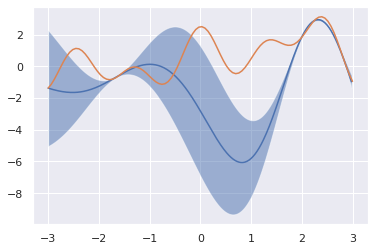

In [26]:
plt.fill_between(x=gp_prior["X"], y1=mu.reshape(
    len(mu)) + 5*std, y2=mu.reshape(len(mu)) - 5*std, alpha=0.50)
plt.plot(gp_prior["X"], mu)

plt.plot(jnp.linspace(MIN, MAX, 100), func(jnp.linspace(MIN, MAX, 100)))


Kernel manipulations.

``` 
    X_data: X = X
    X_subset: X_subset = Z

    N = 300
    M = 5
```

In [27]:
K_z = kernel_functions.rbf_kernel(X, X_subset)
K_zz = kernel_functions.rbf_kernel(X_subset, X_subset)

In [28]:
K_wave = K_z @ np.linalg.solve(K_zz, K_z.T)

In [38]:
sigma_y = 0.2
X_m = jnp.linspace(-0.5,0.5, 5)

In [39]:
X_np = np.array(X)
y_np = np.array(y)
X_m_np = np.array(X_m)

In [40]:
from kernel import variational

def nlb(X_np, y_np, sigma_y):
    return variational.nlb_fn(X_np, y_np, sigma_y)

In [41]:
nlb(X_np, y_np, sigma_y)


<function kernel.variational.nlb_fn.<locals>.nlb_grad_wrapper(parameters)>

In [42]:
from kernel import variational
res = minimize(fun=variational.nlb_fn(X_np, y_np, sigma_y),
               x0=preprocess.pack(jnp.array([1.0, 1.0]), X_m_np),
               method='Nelder-Mead',
               jac=True)

# Optimized kernel parameters and inducing inputs
theta_opt, X_m_opt = preprocess.unpack(res.x)


In [43]:
minimize(fun=variational.nlb_fn(X_np, y_np, sigma_y),
         x0=preprocess.pack(jnp.array([1.0, 1.0]), X_m_np),
         method='Nelder-Mead',
         jac=True)


 final_simplex: (array([[ 5.63317963e-01,  5.75145405e-01, -6.88965771e-01,
        -1.58836665e-02,  2.07716725e-03,  1.43971184e+00,
         2.33752459e+00],
       [ 5.63317963e-01,  5.75145405e-01, -6.88965768e-01,
        -1.58836623e-02,  2.07716706e-03,  1.43971183e+00,
         2.33752460e+00],
       [ 5.63317958e-01,  5.75145412e-01, -6.88965795e-01,
        -1.58836408e-02,  2.07716713e-03,  1.43971185e+00,
         2.33752462e+00],
       [ 5.63317962e-01,  5.75145404e-01, -6.88965781e-01,
        -1.58836506e-02,  2.07716704e-03,  1.43971183e+00,
         2.33752461e+00],
       [ 5.63317961e-01,  5.75145410e-01, -6.88965805e-01,
        -1.58836401e-02,  2.07716727e-03,  1.43971185e+00,
         2.33752461e+00],
       [ 5.63317960e-01,  5.75145420e-01, -6.88965793e-01,
        -1.58836421e-02,  2.07716708e-03,  1.43971185e+00,
         2.33752462e+00],
       [ 5.63317966e-01,  5.75145410e-01, -6.88965838e-01,
        -1.58836197e-02,  2.07716731e-03,  1.43971185e+00,
 

In [44]:
mu_m_opt, A_m_opt, K_mm_inv = variational.optimizer(theta_opt, X_m_opt, X, y, sigma_y)


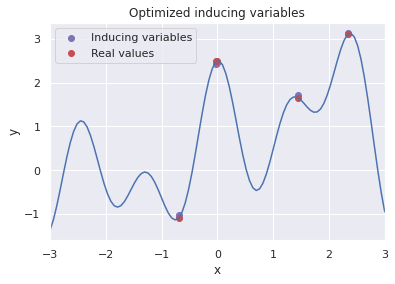

In [45]:

plt.plot(jnp.linspace(MIN, MAX, 100), func(jnp.linspace(MIN, MAX, 100)))
plt.scatter(X_m_opt, mu_m_opt, label='Inducing variables', c='m')
plt.scatter(X_m_opt, func(X_m_opt), label='Real values', c='r')
plt.title('Optimized inducing variables')
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(-3, 3)
plt.legend()

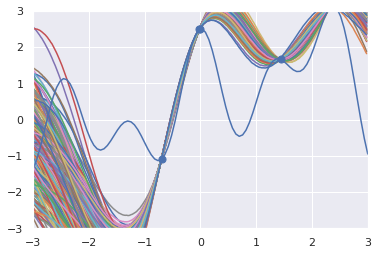

In [46]:
X_subset = X_m_opt
y_subset = func(X_subset)
plt.scatter(X_subset, y_subset, s=5e1)
plt.plot(jnp.linspace(MIN, MAX, 100), func(jnp.linspace(MIN, MAX, 100)))

gp_posterior, gp_post_dict, mu, std = gp.gaussian_posterior(
    gp_prior=gp_prior_sample, X_data=X_subset, Y_data=y_subset, X_test=X_test)
for i in range(gp_prior_sample.shape[1]):
    plt.plot(gp_post_dict["X"], gp_posterior[i], zorder=0.9)

plt.xlim([-3, 3])
plt.ylim([-3,3])
plt.show()


In [1]:
import numpy as np
import tensorflow as tf

import tensorflow_probability as tfp

tfd = tfp.distributions
tfk = tfp.math.psd_kernels


def _add_diagonal_jitter(matrix, jitter=1e-8):
    return tf.linalg.set_diag(matrix, tf.linalg.diag_part(matrix) + jitter)


class SVIGP_Hensman:

    def __init__(self, fixed_inducing_points, initial_inducing_points,
                 name, jitter, N_train, dtype, L, fixed_gp_params, object_vectors_init, K_obj_normalize=False):
        """
        Class for SVGP model from Hensman (2013).
        :param fixed_inducing_points:
        :param initial_inducing_points:
        :param name: name (or index) of the latent channel
        :param jitter: jitter/noise for numerical stability
        :param N_train: number of training datapoints
        :param L: number of latent channels used in SVGPVAE
        :param fixed_gp_params:
        :param object_vectors_init: initial value for object vectors (PCA embeddings).
                        If None, object vectors are fixed throughout training. GPLVM
        :param K_obj_normalize: whether or not to normalize object linear kernel
        """

        self.dtype = dtype
        self.jitter = jitter
        self.nr_inducing = len(initial_inducing_points)
        self.N_train = N_train
        self.L = L
        self.K_obj_normalize = K_obj_normalize

        # u (inducing points)
        if fixed_inducing_points:
            self.inducing_index_points = tf.constant(
                initial_inducing_points, dtype=self.dtype)
        else:
            self.inducing_index_points = tf.Variable(initial_inducing_points, dtype=self.dtype,
                                                     name='Sparse_GP_inducing_points_{}'.format(name))

        # GP hyperparams
        if fixed_gp_params:
            self.l_GP = tf.constant(1.0, dtype=self.dtype)
            self.amplitude = tf.constant(1.0, dtype=self.dtype)
        else:
            self.l_GP = tf.Variable(
                initial_value=1.0, name="GP_length_scale_{}".format(name), dtype=self.dtype)
            self.amplitude = tf.Variable(
                initial_value=1.0, name="GP_amplitude_{}".format(name), dtype=self.dtype)

        # kernels
        self.kernel_view = tfk.ExpSinSquared(
            amplitude=self.amplitude, length_scale=self.l_GP, period=2 * np.pi)
        self.kernel_object = tfk.Linear()

        # object vectors (GPLVM)
        if object_vectors_init is not None:
            self.object_vectors = tf.Variable(initial_value=object_vectors_init,
                                              name="GP_object_vectors_{}".format(
                                                  name),
                                              dtype=self.dtype)
        else:
            self.object_vectors = None

        # (inner) variational parameters
        self.variational_inducing_observations_loc = [tf.Variable(np.zeros([self.nr_inducing], dtype=self.dtype),
                                                                  name='GP_var_params_mu_{}'.format(l + 1)) for l in range(self.L)]

        self.variational_inducing_observations_scale = [tf.Variable(np.eye(self.nr_inducing, dtype=self.dtype),
                                                                    name='GP_var_params_A_{}'.format(l + 1)) for l in range(self.L)]

        self.variational_inducing_observations_cov_mat = [tf.matmul(x, tf.transpose(x)) for x in
                                                          self.variational_inducing_observations_scale]

        self.noise = tf.Variable(
            initial_value=0.1, name="Hensman_likelihood_noise", dtype=self.dtype)

    def kernel_matrix(self, x, y, x_inducing=True, y_inducing=True, diag_only=False):
        """
        Computes GP kernel matrix K(x,y). Kernel from Casale's paper is used for rotated MNIST data.
        :param x:
        :param y:
        :param x_inducing: whether x is a set of inducing points (ugly but solution using tf.shape did not work...)
        :param y_inducing: whether y is a set of inducing points (ugly but solution using tf.shape did not work...)
        :param diag_only: whether or not to only compute diagonal terms of the kernel matrix
        :return:
        """

        # unpack auxiliary data
        if self.object_vectors is None:
            x_view, x_object, y_view, y_object = x[:,
                                                   1], x[:, 2:], y[:, 1], y[:, 2:]
        else:
            x_view, y_view = x[:, 1], y[:, 1]
            if x_inducing:
                x_object = x[:, 2:]
            else:
                x_object = tf.gather(self.object_vectors,
                                     tf.cast(x[:, 0], dtype=tf.int64))
            if y_inducing:
                y_object = y[:, 2:]
            else:
                y_object = tf.gather(self.object_vectors,
                                     tf.cast(y[:, 0], dtype=tf.int64))

        # compute kernel matrix
        if diag_only:
            view_matrix = self.kernel_view.apply(tf.expand_dims(
                x_view, axis=1), tf.expand_dims(y_view, axis=1))
        else:
            view_matrix = self.kernel_view.matrix(tf.expand_dims(
                x_view, axis=1), tf.expand_dims(y_view, axis=1))

        if diag_only:
            object_matrix = self.kernel_object.apply(x_object, y_object)
            if self.K_obj_normalize:
                obj_norm = tf.math.reduce_euclidean_norm(x_object, axis=1) * tf.math.reduce_euclidean_norm(y_object,
                                                                                                           axis=1)
                object_matrix = object_matrix / obj_norm
        else:
            object_matrix = self.kernel_object.matrix(x_object, y_object)
            if self.K_obj_normalize:  # normalize object matrix
                obj_norm = 1 / tf.matmul(tf.math.reduce_euclidean_norm(x_object, axis=1, keepdims=True),
                                         tf.transpose(tf.math.reduce_euclidean_norm(y_object, axis=1, keepdims=True),
                                                      perm=[1, 0]))
                object_matrix = object_matrix * obj_norm

        return view_matrix * object_matrix

    def variable_summary(self):
        """
        Returns values of parameters of sparse GP object. For debugging purposes.
        :return:
        """

        return self.l_GP, self.amplitude, self.object_vectors, self.inducing_index_points

    def variational_loss(self, x, z, lat_channel):
        """
        Computes L_H for the data in the current batch.
        :param x: auxiliary data for current batch (batch, 1 + 1 + M)
        :param z: latent variables for current latent channel (batch, 1)
        :param lat_channel: latent channel index
        :return: sum_term, KL_term (variational loss = sum_term + KL_term)  (1,)
        """
        b = tf.shape(x)[0]
        m = self.inducing_index_points.get_shape()[0]
        b = tf.cast(b, dtype=self.dtype)
        m = tf.cast(m, dtype=self.dtype)

        # kernel matrices
        K_mm = self.kernel_matrix(
            self.inducing_index_points, self.inducing_index_points)  # (m,m)
        K_mm_inv = tf.linalg.inv(
            _add_diagonal_jitter(K_mm, self.jitter))  # (m,m)

        K_nn = self.kernel_matrix(
            x, x, x_inducing=False, y_inducing=False, diag_only=True)  # (b)

        K_nm = self.kernel_matrix(
            x, self.inducing_index_points, x_inducing=False)  # (b, m)
        K_mn = tf.transpose(K_nm, perm=[1, 0])  # (m, b)

        variational_inducing_observations_loc = self.variational_inducing_observations_loc[
            lat_channel]
        variational_inducing_observations_cov_mat = self.variational_inducing_observations_cov_mat[
            lat_channel]

        # K_nm \cdot K_mm_inv \cdot m,  (b,)
        mean_vector = tf.linalg.matvec(K_nm,
                                       tf.linalg.matvec(K_mm_inv, variational_inducing_observations_loc))

        S = variational_inducing_observations_cov_mat

        # KL term
        K_mm_chol = tf.linalg.cholesky(_add_diagonal_jitter(K_mm, self.jitter))
        S_chol = tf.linalg.cholesky(
            _add_diagonal_jitter(variational_inducing_observations_cov_mat, self.jitter))
        K_mm_log_det = 2 * \
            tf.reduce_sum(tf.log(tf.linalg.diag_part(K_mm_chol)))
        S_log_det = 2 * tf.reduce_sum(tf.log(tf.linalg.diag_part(S_chol)))

        KL_term = 0.5 * (K_mm_log_det - S_log_det - m +
                         tf.trace(tf.matmul(K_mm_inv, variational_inducing_observations_cov_mat)) +
                         tf.reduce_sum(variational_inducing_observations_loc *
                                       tf.linalg.matvec(K_mm_inv, variational_inducing_observations_loc)))

        # diag(K_tilde), (b, )
        precision = 1 / self.noise

        K_tilde_terms = precision * \
            (K_nn - tf.linalg.diag_part(tf.matmul(K_nm, tf.matmul(K_mm_inv, K_mn))))

        # k_i \cdot k_i^T, (b, m, m)
        lambda_mat = tf.matmul(tf.expand_dims(K_nm, axis=2),
                               tf.transpose(tf.expand_dims(K_nm, axis=2), perm=[0, 2, 1]))

        # K_mm_inv \cdot k_i \cdot k_i^T \cdot K_mm_inv, (b, m, m)
        lambda_mat = tf.matmul(K_mm_inv, tf.matmul(lambda_mat, K_mm_inv))

        # Trace terms, (b,)
        trace_terms = precision * tf.trace(tf.matmul(S, lambda_mat))

        # L_3 sum part, (1,)
        L_3_sum_term = -0.5 * \
            (tf.reduce_sum(K_tilde_terms) + tf.reduce_sum(trace_terms))

        return L_3_sum_term, KL_term, mean_vector

    def approximate_posterior_params(self, index_points_test, lat_channel):
        """
        Computes parameters of q_S.
        :param index_points_test: X_*
        :param lat_channel:
        :return: posterior mean at index points,
                 (diagonal of) posterior covariance matrix at index points
        """

        variational_inducing_observations_loc = self.variational_inducing_observations_loc[
            lat_channel]
        variational_inducing_observations_cov_mat = self.variational_inducing_observations_cov_mat[
            lat_channel]

        K_mm = self.kernel_matrix(
            self.inducing_index_points, self.inducing_index_points)  # (m,m)
        K_mm_inv = tf.linalg.inv(
            _add_diagonal_jitter(K_mm, self.jitter))  # (m,m)
        K_xx = self.kernel_matrix(index_points_test, index_points_test, x_inducing=False,
                                  y_inducing=False, diag_only=True)  # (x)
        K_xm = self.kernel_matrix(
            index_points_test, self.inducing_index_points, x_inducing=False)  # (x, m)

        A = tf.matmul(K_xm, K_mm_inv)

        mean_vector = tf.linalg.matvec(
            A, variational_inducing_observations_loc)

        mid_mat = K_mm - variational_inducing_observations_cov_mat
        B = K_xx - tf.matmul(A, tf.matmul(mid_mat,
                             tf.transpose(A, perm=[1, 0])))

        return mean_vector, B


2022-10-07 00:21:43.707166: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-07 00:21:43.882832: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-07 00:21:44.597728: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/compilers/openmpi/4.1.2/lib64/openmpi:/opt/compilers/openmpi/4.1.2/lib64:/usr/local/cuda/lib64:/opt/compilers/openmpi/4.1.2/lib64/openmpi:/opt/compilers/openmpi/4.1.2/lib64:/usr/local/cuda/lib64:
2022-10-07 

Variational part
Surface of the loss function -- plot
